In [1]:
#|default_exp conv

In [2]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [3]:

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

import torch.nn.functional as F
import torch

from torch.utils.data import DataLoader
from typing import Mapping
     

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
path_data = Path('../data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

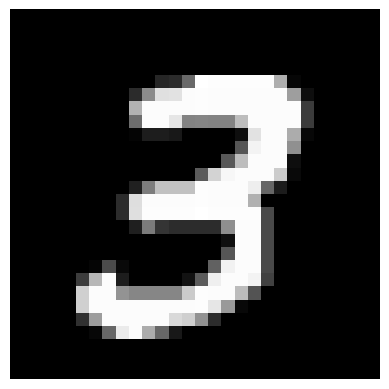

In [6]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

im3 = x_imgs[7]
show_image(im3);

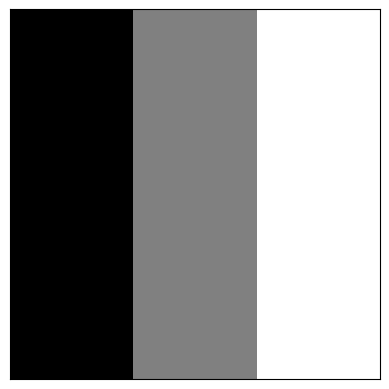

In [7]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()
show_image(left_edge, noframe=False);


In [8]:
inp = im3[None,None,:,:].float() # First None for batch size, Second for Channel size BCHW
inp_unf = F.unfold(inp, (3,3))[0] # unfolds image to work with 3x3 kernel
inp_unf.shape

torch.Size([9, 676])

In [9]:
w = left_edge.view(-1) # weights unfolded from left edge detector image
w.shape

torch.Size([9])

In [10]:
out_unf = (w@inp_unf) # now with input and kernel unfolded a direct dot product will give us the convolution output
out_unf.shape

torch.Size([676])

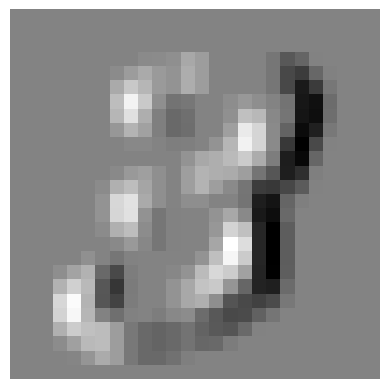

In [11]:
out = out_unf.view(26,26) # Unfold the output back into the image dimensions
show_image(out);

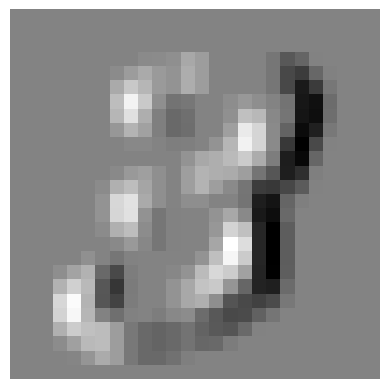

In [12]:
out = F.conv2d(inp, left_edge[None,None]) # Pytorch functional conv2d does the same thing
show_image(out[0][0]);

Now we create 4 kernels to use with a batch of images

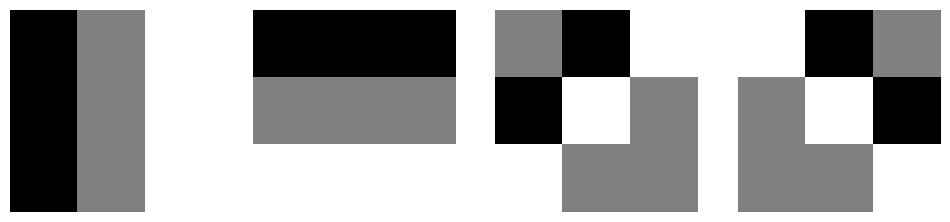

In [13]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()
show_images([left_edge, top_edge, diag1_edge, diag2_edge], ncols=4)

Our image batch

In [14]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

Our kernels

In [15]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape


torch.Size([4, 1, 3, 3])

In [16]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

Now compare input to outputs for single image

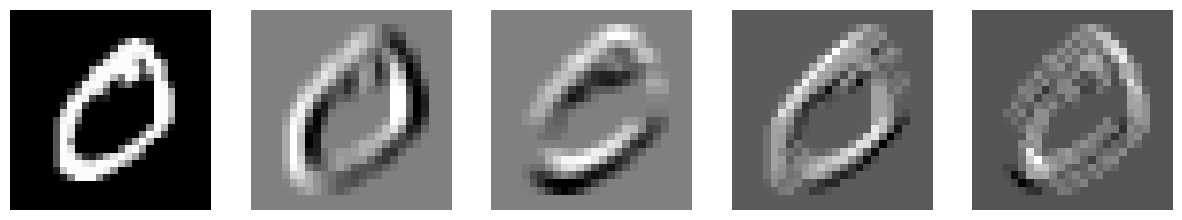

In [17]:
img0 = xb[1,0]
out_features = [batch_features[1,i] for i in range(4)]
show_images([img0, *out_features], ncols=5);



Now we will setup an actual convolutional network.  This will require the use of a stride to downsize the outputs until we get to a number of output features that can be used as predictions.

In [18]:
#|export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [19]:
simple_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten(),
)
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [20]:
x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)


In [21]:
#|export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))
def_device

'mps'

In [22]:
from torch import optim

bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)


In [23]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 1.0030897212982177 0.7076000002861023
1 0.24584428868293762 0.9234999998092651
2 0.15890723934173584 0.9499000005722046
3 0.26399456176757813 0.9246999998092651
4 0.10695730490684509 0.9696999994277954


In [24]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)


0 0.08530726554393768 0.9761999995231628
1 0.08355792925357819 0.976599999332428
2 0.08091873435974122 0.976299999332428
3 0.08186185593605041 0.9778999995231629
4 0.08474074730873107 0.9746999994277954


In [25]:
import nbdev; nbdev.nbdev_export()
